In [1]:
from utils import *
from vqls import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
verbose = False

In [3]:
lower = -1.
upper = 1. 
step = .1
optimizer='COBYLA'
func_out = {'sigmoid': sigmoid,'tanh': tanh,'elu': elu, 'relu': relu, 'sin':sin_m}
func_dict = {'sigmoid': .0,'tanh': 1.0,'elu':.12, 'relu':.0, 'sin':.0}

nq=1 #number of qubits, 1 for 2x2 matrix inversion

# "denormalizations" options. only for visualize the penalties
y_norm=False
point_norm=False
both = False

#to visualize the condition number plot
visualize_k_numb=False  


In [4]:
# function specific 
label = 'tanh'

#elu 0.1,0.0, relu 0.0 0.0, tanh 1. 1.0
f_i = func_dict[label]
f_e = f_i

func = func_out[label]


In [5]:
# Create the function
x = np.arange(lower, upper + .03, step).tolist()
y = [func(value,f_i) for value in x]

#############################################################################################
################################# SubSystemMatrices Procedure ###############################
#############################################################################################

M = []
Y = []

for i in range(1, len(x)):
    eq1 = pd.Series([1, x[i - 1]])
    eq2 = pd.Series([1, x[i]])
    M_c = pd.concat([eq1, eq2], axis=1).transpose()
    Y.append([y[i - 1], y[i]])
    M.append(M_c)


In [6]:
q_weights=[]
c_coeff=[]
beta_q=[]
v_norms=[]
k_list=[]


In [7]:
for i in range(len(M)):
    print('index ',i)
    matrix = M[i]
    vector = Y[i]
    if vector == [0.0, 0.0]:
        #y = [el + 10 ** -4 for el in y]
        vector = [.000001, 0.00001] # the relu case
    v_norm = vector/np.linalg.norm(vector)
    v_norms.append(np.linalg.norm(vector))
    
    if verbose:
        print('Matrix\n',matrix)
        print('matrixnp\n',np.array(matrix))
        k_numb=np.linalg.cond(np.array(matrix))
        print('Condition number\n',k_numb)
        k_list.append(k_numb)
        print('yk     :',vector)
        print('norm(yk)',np.linalg.norm(vector))
        print('yk_norm:',v_norm)

    vqls_circuit = VQLS(matrix,v_norm,nq,opt=optimizer) 
    print('Optimizing variational params..')
    weights = vqls_circuit.train(max_iter=200) 
    q_weights.append(weights)
    q = vqls_circuit.solution(weights)
    beta_q.append(q)
    c = np.linalg.solve(matrix,vector)
    c_coeff.append(c)

    if verbose:
        print('Quantum coefficients         :',q)
        print("Variational Circuit's weights:",weights)
        print('beta_classic                 :',c)


index  0
Optimizing variational params..
index  1
Optimizing variational params..
index  2
Optimizing variational params..
index  3
Optimizing variational params..
index  4
Optimizing variational params..
index  5
Optimizing variational params..
index  6
Optimizing variational params..
index  7
Optimizing variational params..
index  8
Optimizing variational params..
index  9
Optimizing variational params..
index  10
Optimizing variational params..
index  11
Optimizing variational params..
index  12
Optimizing variational params..
index  13
Optimizing variational params..
index  14
Optimizing variational params..
index  15
Optimizing variational params..
index  16
Optimizing variational params..
index  17
Optimizing variational params..
index  18
Optimizing variational params..
index  19
Optimizing variational params..


In [8]:
# Sampling points within intervals
X = []
for i in range(1, len(x)):
    X.append(np.arange(x[i - 1], x[i], step - 0.01).tolist())


In [9]:
#############################################################################################
######################################## Inner Product ######################################
#############################################################################################

qc_full = []
classic_prod = []
print('Classic and Quantum Product estimation..')



for i in range(len(X)):
    print('Index',i)
    for x in X[i]:
        point = [1,x]
        #classic_prod
        classic_prod.append(c_coeff[i][0]+x*c_coeff[i][1])
        #quantum_prod with/without norm
        if y_norm:
            norm=v_norms[i]
        elif point_norm:
            norm=np.linalg.norm(point)
            print('point',point)
            print('norm(point)',norm)
            print('point_norm',point/norm)
        elif both:
            print('v_norms[i]',v_norms[i])
            print('point',np.linalg.norm(point))
            norm= v_norms[i]*np.linalg.norm(point)
            print('norm',norm)
        else:
            norm = 1

        qc_full.append(vqls_circuit.direct_prod2(q_weights[i],point,visualize=False)*norm)  


Classic and Quantum Product estimation..
Index 0
Index 1
Index 2
Index 3
Index 4
Index 5
Index 6
Index 7
Index 8
Index 9
Index 10
Index 11
Index 12
Index 13
Index 14
Index 15
Index 16
Index 17
Index 18
Index 19


In [10]:
x = [item for sublist in X for item in sublist]
y = [func(value,f_e) for value in x]


##### TODO: ???????????????????????????????????????????????????????????????????
if label == 'tanh':
    qc_full = [q - 0.2 for q in qc_full] 
if label == 'elu':
    classic_prod = [c -f_i for c in classic_prod]
    qc_full = [c-f_i for c in qc_full]


rss_full = np.sum(np.square(np.array(y) - np.array(qc_full)))
print('RSS:',rss_full)





RSS: 1.5037587706040911


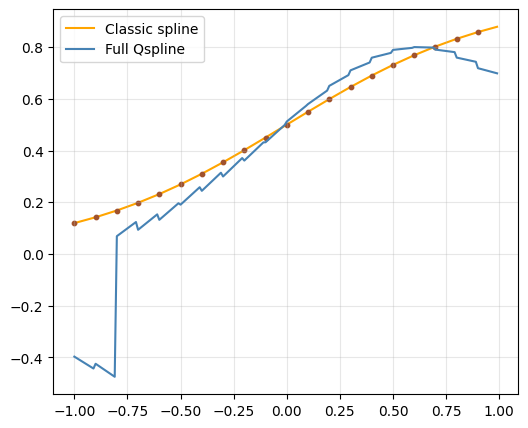

In [11]:
#############################################################################################
######################################## Visualization ######################################
#############################################################################################
                                                    
type = 'Full'
x_cond = [(X[i][0]+X[i][1])/2 for i in range(len(X))]

x1=[i for j,i in enumerate(x) if j%2==0]
y1=[i for j,i in enumerate(y) if j%2==0]

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(x, classic_prod, color='orange', label='Classic spline',zorder=1)  
ax.plot(x, qc_full, color='steelblue',label=type + ' Qspline') 
ax.scatter(x1,y1,color='sienna',s=10)

ax.grid(alpha=0.3)
plt.legend(loc='best')
plt.show()

if visualize_k_numb:
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.scatter(x_cond, k_list, color='cornflowerblue', label='ConditionNumber', s=10)
    ax.grid(alpha=0.3)
    plt.legend(loc='best')
    plt.show()
